In [1]:
%run utils.ipynb

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [4]:
df=pd.read_csv("../data/train.csv")

#drop some useless columns
cols_to_drop=["Id","PID"]
df=df.drop(columns=cols_to_drop)

#drop outliers identified in part 1
df=df[df['Gr Liv Area']<=4500]
df=df[df['SalePrice']>np.expm1(10)]

df_copy=df.copy()

In [5]:
correlated_to_drop=["1st Flr SF","Garage Yr Blt","TotRms AbvGrd","Garage Area"]

### Let's run a simple Linear Regression using all the numerical features

### Set up model

In [6]:
#set up X and Y
X=df.drop(columns="SalePrice")
y=df["SalePrice"]

#make a backup copy
X_copy=X.copy()
y_copy=y.copy()

#### Set up a `TransformedTargetRegressor` to handle the log / exponential transformation of the label  
Uses Pipeline to perform preprocessing and prediction

In [7]:
#Create a regressor to dynamically creates a pipeline
def create_regressor(model,**kwargs):
    '''
    model: estimator instance
    return: TransformedTargetRegressor
    '''
    pipeline=Pipeline(steps=[
        ('drop_correlated',DropCorrelated(correlated_to_drop)),
        ('ms_subclass_convert',MSSubClassConvert()),
        ('selector',FeatureSelector(**kwargs)),
        ('impute_zero',ImputeZero()),
#         ('align_train_and_predict',AlignTrainPredict()), #This is to align the train and predict DF in case they are different
        ('passthrough',Passthrough()), #Passthrough step, does nothing. Only exists to allow external code to retrieve feature names.
        ('model',model)
    ])
        
    return TransformedTargetRegressor(regressor=pipeline,
                                    func=np.log1p,
                                    inverse_func=np.expm1)

In [8]:
RMSE=[]
coefficients=[]
feature_names=None

#create regressor and instruct to keep only numerical features
lr=create_regressor(LinearRegression(),by="numerical")

#run 10 K Folds and store the coefficients and RMSE to a list.
kf=KFold(n_splits=10,random_state=30,shuffle=True)
for train_index, test_index in kf.split(X_copy.copy()):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lr.fit(X_train,y_train)
    ypred=lr.predict(X_test)
    RMSE.append(mean_squared_error(y_test,ypred,squared=False))
    coefficients.append(lr.regressor_['model'].coef_)
    feature_names=list(lr.regressor_['passthrough'].get_feature_names())

In [9]:
np.mean(RMSE)

23331.23663436534

Wow, this is better than what we had in part 1 (27098).  
However, this is becuase we used **all** numerical features.  
Let's try to dynamically iterate through all variables, and find the top X numbers to use.

Let's try again with reduced number of features.

In [10]:
dfcoeff=np.abs(pd.DataFrame(coefficients,columns=feature_names).mean()).sort_values(ascending=False)

In [11]:
results=[]

for coeff_top_x in range(3,len(feature_names)+1):
    # features_to_keep
    features_to_keep=list(dfcoeff.head(coeff_top_x).index)
    
    RMSE=[]

    lr=create_regressor(LinearRegression(),feature_names=features_to_keep)

    kf=KFold(n_splits=10,random_state=30,shuffle=True)
    for train_index, test_index in kf.split(X_copy.copy()):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        lr.fit(X_train,y_train)
        ypred=lr.predict(X_test)
        RMSE.append(mean_squared_error(y_test,ypred,squared=False))

    results.append({'feat_count':coeff_top_x,'RMSE':np.mean(RMSE)})

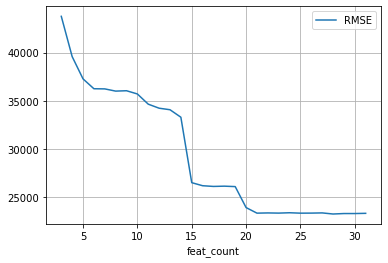

In [12]:
ax=pd.DataFrame(results).plot(x="feat_count",y="RMSE",grid=True)
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)

Sweet spot seems to be a sweet spot at 21, about 23000 RMSE.
Let's pick the top 21 features here.

In [13]:
features_to_keep=list(dfcoeff.head(21).index)
features_to_keep

['Kitchen AbvGr',
 'Overall Qual',
 'Overall Cond',
 'Garage Cars',
 'Fireplaces',
 'Bsmt Full Bath',
 'Yr Sold',
 'Half Bath',
 'Bsmt Half Bath',
 'Year Built',
 'Bedroom AbvGr',
 'Full Bath',
 'Year Remod/Add',
 'Lot Frontage',
 'Gr Liv Area',
 'Screen Porch',
 'Low Qual Fin SF',
 '3Ssn Porch',
 'Enclosed Porch',
 'Total Bsmt SF',
 'BsmtFin SF 1',
 'Mo Sold']

### Try a submission

In [15]:
#Instantiate a copy of Tester helper class
tester=Tester("../data/test.csv")

In [16]:
#obtain a copy of the test set
df_test=tester.get_test_df()

In [17]:
#instantiate and train the model
lr=create_regressor(LinearRegression(),feature_names=features_to_keep)
lr.fit(X_copy.copy(),y)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('drop_correlated',
                                                      DropCorrelated(drop=['1st '
                                                                           'Flr '
                                                                           'SF',
                                                                           'Garage '
                                                                           'Yr '
                                                                           'Blt',
                                                                           'TotRms '
                                                                           'AbvGrd',
                                                                           'Garage '
                                                                           'Area'])),
                                                     ('ms_subclass_convert',
                                                      MSSubClassConvert()),
                                                     ('selector',
                                                      FeatureSelector(feature_names=['Kitchen '
                                                                                     'AbvGr',
                                                                                     'Overall '
                                                                                     'Qual',
                                                                                     'Overall '
                                                                                     'Cond',
                                                                                     'Gara...
                                                                                     'Bath',
                                                                                     'Yr '
                                                                                     'Sold',
                                                                                     'Half '
                                                                                     'Bath',
                                                                                     'Bsmt '
                                                                                     'Half '
                                                                                     'Bath',
                                                                                     'Year '
                                                                                     'Built',
                                                                                     'Bedroom '
                                                                                     'AbvGr',
                                                                                     'Full '
                                                                                     'Bath',
                                                                                     'Year '
                                                                                     'Remod/Add',
                                                                                     'Lot '
                                                                                     'Frontage',
                                                                                     'Gr '
                                                                                     'Liv '
                                                                                     'Area',
                                                                                     'Screen '
                                                                             

In [18]:
#make prediction
ypred=lr.predict(df_test)

In [19]:
tester.write_submission(ypred,"../data/02_all_features_submission.csv")

Output saved to ../data/02_all_features_submission.csv
